# Calculate Run Value from Pitch by Pitch Data

## Purpose:
### Prepare model to apply to synergy data to create similar matrix to the college baseball run environment, more specifically the CAA.

## Deriving run values from pitch by pitch data from the 2022 regular season:
### 1. Create a column containing the count-out-base state for each pitch.
### 2. Split the data into individual half-innings.
### 3. For each half-inning, create a new column that holds the difference in runs scored by the end of the half-inning compared to the beginning.
### 4. Iterate through each pitch, adding the value in the 'runs_by_end' column to the existing run value for that state and increasing the count of times that state has occurred in a dictionary of states and run values. If the state is not already in the dictionary, add it with the value of 'runs_by_end' and a count of 1.
### 5. For each state in the dictionary, divide the total run value by the number of times that state occurred to calculate the average runs scored by the end of the half-inning when that state is present.
### 6. Create a new dictionary with the states as keys and the average runs scored as values.

In [1]:
import pybaseball as pyb
import pandas as pd
from collections import defaultdict
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import reece_calvin as rc
import matplotlib.pyplot as plt
import random

## The following functions stored on my reece_calvin library

#### slope_intercept(df, x, y):
    calculate the slope and coefficient for a linnear regression that has one independent variablec
    intercept, coefficient

#### linnear_func(df, x, y, intercept, coefficient):
    adds a row for y as a from the intercept, x, and coefficient

In [2]:
def inning_game_ids(pxp):
    """
    Categorize plays based on game names and innings
    
    pxp: DataFrame
        DataFrame of play by play data
        
    Returns:
        DataFrame of categorized plays with game_id and inning_id columns
    """
    plays = []
    game_id = 0
    inning_id = 0
    game = None
    inning = None
    
    for play in pxp.to_dict('records'):
        current_game = play.get('Notes')
        current_inning = play.get('Inning')
        
        if current_game != game:
            game_id += 1
            inning_id += 1
            game = current_game
            inning = current_inning
        elif current_inning != inning:
            inning_id += 1
            inning = current_inning
        
        play['game_id'] = game_id
        play['inning_id'] = inning_id
        plays.append(play)
    
    return pd.DataFrame(plays)

def base_count_score(pxp):
    """
    Process play-by-play data by splitting scores, counts, and runners on base
    
    pxp: DataFrame
        DataFrame of play by play data
        
    Returns:
        DataFrame of processed play-by-play data with added columns for bat_score, 
        balls, strikes, on_1b, on_2b, and on_3b
    """
    data = pxp.to_dict('records')
    
    for play in data:
        score = play['Score'].split('-')
        if play['Inning'][0] == 'T':
            play['bat_score'] = int(score[0])
        else:
            play['bat_score'] = int(score[1])
        
        count = play['Count'].split('-')
        play['balls'] = count[0]
        play['strikes'] = count[1]
        
        play['on_1b'] = 1 if '1B' in play['Runners On Base'] else 0
        play['on_2b'] = 1 if '2B' in play['Runners On Base'] else 0
        play['on_3b'] = 1 if '3B' in play['Runners On Base'] else 0
    
    return pd.DataFrame(data)


def seperate_bunts(row):
    '''
    If the BIP Type is a bunt, make that the event as opposed to 'Single' or 'Groundout'
    '''
    if row['BIP Type'] in bunts:
        row['event'] = row['BIP Type']
    return row

def add_lineup_number(df):
    '''
    Process play-by-play data to add lineup number
    
    df: DataFrame
        DataFrame of play by play data
        
    Returns:
        DataFrame of processed play-by-play data with added column for lineup number
    '''
    data = df.to_dict('records')
    
    current_game = None
    current_batter = None
    lineup_number = 0
    
    for play in data:
        if current_game != play['gameId']:
            current_game = play['gameId']
            current_batter = play['batterId']
            lineup_number = 1
            
        if current_batter != play['batterId']:
            current_batter = play['batterId']
            if lineup_number == 9:
                lineup_number = 1
            else:
                lineup_number += 1
            
        play['lineup_number'] = lineup_number
        
    return pd.DataFrame(data)

def event_run(event,pxp):
    event_run = pxp.loc[pxp['event'].isin(event)]
    event_run = event_run[['state','run_scored_by_end?']].groupby(['state']).mean()
    return event_run

def event_rv(event):
    event_rv = pxp_updated.loc[pxp_updated['event'].isin(event)]
    event_rv = event_rv['delta_run_expectancy'].mean()
    return event_rv


def count_plate_appearances(df):
    '''
    Count plate appearances
    
    df: DataFrame
        DataFrame of play by play data
        
    Returns:
        Dictionary of plate appearances by game and lineup number
    '''
    plate_appearances = {}
    data = df.to_dict('records')
    current_game = None
    current_hitter = None
    
    for play in data:
        if current_game != play["gameId"]:
            current_game = play["gameId"]
            plate_appearances[current_game] = {}
            current_hitter = None
        lineup_number = play["lineup_number"]
        if lineup_number not in plate_appearances[current_game]:
            plate_appearances[current_game][lineup_number] = 0
        if current_hitter != play["batterId"]:
            current_hitter = play["batterId"]
            plate_appearances[current_game][lineup_number] += 1
    
    return plate_appearances

def average_plate_appearance(dictionary):
    result = defaultdict(list)
    for game in dictionary.values():
        for lineup, plate_appearance in game.items():
            result[lineup].append(plate_appearance)
    return {key: sum(value)/len(value) for key, value in result.items()}

def count_plate_appearances_by_outs(df):
    '''
    Count plate appearances by outs
    
    df: DataFrame
        DataFrame of play by play data
        
    Returns:
        DataFrame of plate appearances by outs, sorted by lineup number
    '''
    plate_appearances = {0: {}, 1: {}, 2: {}}
    data = df.to_dict('records')
    current_game = None
    current_hitter = None
    
    for play in data:
        if current_game != play["gameId"]:
            current_game = play["gameId"]
        lineup_number = play["lineup_number"]
        outs = play["Outs"]
        if outs in plate_appearances and lineup_number not in plate_appearances[outs]:
            plate_appearances[outs][lineup_number] = 0
        if outs in plate_appearances and current_hitter != play["batterId"]:
            plate_appearances[outs][lineup_number] += 1
            current_hitter = play["batterId"]
    
    df = pd.DataFrame.from_dict(plate_appearances)
    res = df.div(df.sum(axis=1), axis=0)

    return res.sort_index()


def rob_df(df):
    df['runner_on'] = df['on_1b'] + df['on_2b'] + df['on_3b']
    df['runner_on'] = df['runner_on'] >= 1
    df['runner_on'] = df['runner_on'].astype(int)
    df_grouped = df.groupby('lineup_number').agg({'runner_on': 'sum'})
    df_grouped['PA empty'] = df.groupby('lineup_number').size() - df_grouped['runner_on']
    df_grouped['PA men on'] = df_grouped['runner_on']
    df_grouped['% PA with men on'] = df_grouped['PA men on'] / (df_grouped['PA men on'] + df_grouped['PA empty'])
    df_grouped['# of runners on per game'] = df_grouped['PA men on'] / df_grouped['PA men on'].sum()
    df_grouped = df_grouped.reset_index()
    df_grouped.set_index('lineup_number', inplace=True)
    
    return df_grouped


In [3]:
# simplfies events to shorthand
simple_results = {
    'Double' : '2B',
    'Field Error' : 'RBOE',
    "Fielder's Choice - Out" : 'GO',
    "Fielder's Choice - Safe'" : 'GO',
    'Fly Ball Into Double Play' : 'FO',
    'Flyout' : 'FO',
    'Ground Rule Double' : '2B',
    'Grounded Into Double Play' : 'GO',
    'Groundout' : 'GO',
    'Home Run' : 'HR',
    'Home Run Inside The Park' : 'HR',
    'Infield Fly Rule' : 'IFB',
    'Lined Into Double Play' : 'LO',
    'Lined Into Triple Play' : 'LO',
    'Lineout' : 'LO',
    'Popout' : 'FO',
    'Popped Into Double Play' : 'FO',
    'Sacrifice Bunt' : 'Bunt',
    'Sacrifice Fly' : 'FO',
    'Single' : '1B',
    'Triple' : '3B',
    'Strikeout' : 'K',
    'Walk' : 'BB',
    'Hit By Pitch': 'HBP',
    'Intentional Walk' : 'IBB',
    'Ground Out' : 'GO',
    'Strikeout (Swinging)' : 'K',
    'Pop Out' : 'FO',
    'Single' : '1B',
    "Fielder's Choice" : 'GO',
    'Strikeout (Looking)' : 'K',
    'Walk':'BB',
    'Double': '2B',
    'Sac Bunt':'Bunt',
    'Fly Out' : 'FO',
    'Hit By Pitch':'HBP',
    'Triple' :'3B',
    'Home Run' : 'HR',
    'Line Out' : 'LO',
    "Reached on Fielder's Choice" : 'GO',
    'Reached on Error on a Ground Ball': 'GO',
    'Sac Fly' : 'FO',
    'Bunt Ground Out' : 'Bunt',
    'Bunt Pop Out' : 'Bunt',
    'Reached on Error on a Bunt Ground Ball' : 'Bunt',
    'Reached on Error on a Fly Ball' : 'FO',
    'Intentional Walk' : 'IBB',
    'Reached on Error on a Pop Up' : 'FO',
    'Batter Interference' : 'B-Int',
    'Catcher Interference' : 'C-Int',
    'Reached on Error on a Line Drive' : 'LO',
    'Reached on Error' : 'RBOE',
    'In-the-park Home Run on a Fly Ball': 'HR',
    'Bunt' : 'Bunt'
}

# groups all balls and strikes together
count_result = {
    'Ball' : 'B',
    'Strike Taken' : 'S',
    'Strike Swinging' : 'S',
    'Strikeout' : 'S',
    'Ball' : 'B'
}

# value of each event in terms of ops 
obp_value = {
    'Strikeout (Looking)': 0,
    'Line Out': 0,
    'Ground Out': 0,
    'Walk': 1,
    'Double Play': 0,
    'Hit By Pitch': 1,
    'Single': 1,
    'Strikeout (Swinging)': 0,
    'Fly Out': 0,
    'Double': 1,
    'Pop Out': 0,
    "Fielder's Choice": 0,
    'Home Run': 1,
    'Triple': 1,
    'Intentional Walk': 1,
    'In Play Out': 0,
    'Triple Play': 0,
    'In-the-park Home Run on a Fly Ball': 1
}


# value of event in terms of slg
slugging_values = {
    'Strikeout (Looking)': 0,
    'Line Out': 0,
    'Ground Out': 0,
    'Double Play': 0,
    'Single': 1,
    'Strikeout (Swinging)': 0,
    'Fly Out': 0,
    'Double': 2,
    'Pop Out': 0,
    "Fielder's Choice": 0,
    'Home Run': 4,
    'Triple': 3,
    'In Play Out': 0,
    'Triple Play': 0,
    'In-the-park Home Run on a Fly Ball': 4
}

woba_results = {
    'BB':'BB',
    'HBP':'HPB',
    '1B':'1B',
    '2B':'2B',
    '3B':'3B',
    'HR':'HR',
    'K':'Out',
    'BIP - Out':'Out',
    'BIP - Out':'Out',
    'BIP - Out':'Out',
}

In [4]:
'''# Read all the csv files in folder
cols = list(range(0,20))
folder = '2022 CAA pxp'

dataframes = []
for filename in os.listdir(folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder, filename)
        df = pd.read_csv(file_path, usecols = cols)
        dataframes.append(df)
        
# Combine the dataframes into one
pxp = pd.concat(dataframes, axis=0)

# Add a game id and inning id for each respectively
pxp = inning_game_ids(pxp)

# create a column that has a defined event no matter the context
pxp['event'] = pxp['BIP Result'].fillna(pxp['Non-BIP Result']).fillna(pxp['Pitch Result'])

# Add base state, indivual count, and bat score columns
pxp = base_count_score(pxp)

# If the BIP Type is a bunt, make that the event as opposed to 'Single' or 'Groundout'
bunts = ['Bunt Ground Ball', 'Bunt Popup', 'Bunt', 'Bunt Line Drive']
pxp = pxp.apply(seperate_bunts, axis=1)
'''

'# Read all the csv files in folder\ncols = list(range(0,20))\nfolder = \'2022 CAA pxp\'\n\ndataframes = []\nfor filename in os.listdir(folder):\n    if filename.endswith(".csv"):\n        file_path = os.path.join(folder, filename)\n        df = pd.read_csv(file_path, usecols = cols)\n        dataframes.append(df)\n        \n# Combine the dataframes into one\npxp = pd.concat(dataframes, axis=0)\n\n# Add a game id and inning id for each respectively\npxp = inning_game_ids(pxp)\n\n# create a column that has a defined event no matter the context\npxp[\'event\'] = pxp[\'BIP Result\'].fillna(pxp[\'Non-BIP Result\']).fillna(pxp[\'Pitch Result\'])\n\n# Add base state, indivual count, and bat score columns\npxp = base_count_score(pxp)\n\n# If the BIP Type is a bunt, make that the event as opposed to \'Single\' or \'Groundout\'\nbunts = [\'Bunt Ground Ball\', \'Bunt Popup\', \'Bunt\', \'Bunt Line Drive\']\npxp = pxp.apply(seperate_bunts, axis=1)\n'

In [5]:
# Read all the csv files in folder
folder = 'tru media exports'

dataframes = []
for filename in os.listdir(folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)
        
# Combine the dataframes into one
tm = pd.concat(dataframes, axis=0)

In [6]:
tm['event'] = tm['pitchResult'].fillna('')

tm.loc[tm['event'].str.startswith('Home Run', na=False), 'event'] = 'Home Run'

tm.loc[tm['event'].str.contains('Single', case=False) & ~tm['event'].str.contains(
    'Bunt', case=False), 'event'] = 'Single'

tm.loc[tm['event'].str.contains('Double', case=False) & ~tm['event'].str.contains(
    'Bunt', case=False) & ~tm['event'].str.contains(
    'Double Play', case=False), 'event'] = 'Double'

tm.loc[tm['event'].str.contains('Triple', case=False) & ~tm['event'].str.contains(
    'Bunt', case=False) & ~tm['event'].str.contains(
    'Triple Play', case=False), 'event'] = 'Triple'

tm.loc[tm['event'].str.contains('Bunt', case=False), 'event'] = 'Bunt'

tm['inning_id'] = (tm['gameId'].astype(str) + tm['inn'].astype(str))
tm['ManOn1st'] = tm['ManOn1st'].fillna(0).astype(int)
tm['ManOn2nd'] = tm['ManOn2nd'].fillna(0).astype(int)
tm['ManOn3rd'] = tm['ManOn3rd'].fillna(0).astype(int)
tm.rename(columns={'outs' : 'Outs', 'ManOn1st' : 'on_1b', 'ManOn2nd' : 'on_2b', 'ManOn3rd' : 'on_3b',
                   'currentRuns' : 'bat_score'},inplace =True)

# saves inning as int
tm['inning'] = tm['inn'].astype(str).str[-2:].astype(int)

tm = add_lineup_number(tm)

outs_at_lineup = count_plate_appearances_by_outs(tm)

plate_appearances = count_plate_appearances(tm)

bot_innings = tm[tm['inn'].str.startswith('Bot')].groupby('gameId')

indices_to_drop = [game_df.index.max() for game_id, game_df in bot_innings]
pxp = tm.drop(indices_to_drop)

In [7]:
# Some rows are tagged with -1 or 3 outs
pxp = pxp.loc[pxp['Outs'] >= 0]
pxp = pxp.loc[pxp['Outs'] < 3]

# Create a game state column
pxp['state'] = (
    #pxp['balls'].astype(str) + 
    #pxp['strikes'].astype(str) +
    pxp['Outs'].astype(str) + 
    pxp['on_1b'].astype(str) + 
    pxp['on_2b'].astype(str) + 
    pxp['on_3b'].astype(str)
)

# Add a column to show what number a batter is in the lineup
# pxp = add_lineup_number(pxp)

# Calculate runs scored by end of each inning from the current state
runs_by_end = pxp.groupby('inning_id')['bat_score'].max()
pxp['runs_at_end'] = pxp['inning_id'].map(runs_by_end)
pxp['runs_by_end'] = pxp['runs_at_end'] - pxp['bat_score']

# Calculate the run expectancy for each state
state_run_expectancy = pxp.groupby('state')['runs_by_end'].mean()

pxp['run_expectancy'] = pxp['state'].map(state_run_expectancy)

pxp['runs_scored'] = pxp['bat_score'].shift(-1) - pxp['bat_score']
inning_match = pxp['inning_id'].eq(pxp['inning_id'].shift(-1))
pxp['runs_scored'] = pxp['runs_scored'].where(inning_match, 0)

pxp['delta_run_expectancy'] = pxp['run_expectancy'].shift(-1) - pxp['run_expectancy'] + pxp['runs_scored']
pxp['delta_run_expectancy'] -= pxp['run_expectancy'].where(inning_match, 0)

next_re = pxp['run_expectancy'].shift(-1)
mask = pxp['inning_id'] == pxp['inning_id'].shift(-1)
pxp['delta_run_expectancy'] = np.where(mask, next_re - pxp['run_expectancy'] + pxp['runs_scored'],
                                       -pxp['run_expectancy'] + pxp['runs_scored'])

pxp[['run_value']] = pxp[['delta_run_expectancy']] + pxp[['delta_run_expectancy']].mean() * -1

# At least 1 run scored?
pxp['run_scored_by_end?'] = [1 if x > 0 else 0 for x in pxp['runs_by_end']]

pxp.reset_index(inplace = True)

pxp['simple_results'] = pxp.event.map(simple_results)
pxp['woba_results'] = pxp['simple_results'].map(woba_results)

simple_run_value = pxp[['run_value','simple_results']].groupby('simple_results').mean()['run_value']
pxp['xRV'] = pxp['simple_results'].map(simple_run_value)

pxp = pxp.loc[~pxp['inning_id'].isin(list(
    pxp.dropna(subset='simple_results').loc[pxp.dropna(subset='simple_results')['delta_run_expectancy'] == 0]
    ['inning_id'].unique()))]

In [13]:
pxp.groupby('pitchTypeFull').mean()[['run_value']].sort_values('run_value', ascending = False)

,run_value
pitchTypeFull,
Intentional Ball,0.146281
Two Seamer,0.019683
Fastball,0.007345
Cutter,-0.000193
Changeup,-0.011131
Curveball,-0.012395
Pitchout,-0.015577
Slider,-0.017122
Knuckleball,-0.019905


In [14]:
# Calculate runs scored by end of each inning from the current state
runs_by_end = pxp.groupby('inning_id')['bat_score'].max()
pxp['runs_at_end'] = pxp['inning_id'].map(runs_by_end)
pxp['runs_by_end'] = pxp['runs_at_end'] - pxp['bat_score']

# Calculate the run expectancy for each state
state_run_expectancy = pxp.groupby('state')['runs_by_end'].mean()

pxp['run_expectancy'] = pxp['state'].map(state_run_expectancy)

## Build Base State Run Expectancy Matrix

In [15]:
matrix = pd.DataFrame(list(state_run_expectancy.items()), columns=['keys', 'values'])
matrix['Outs'] = matrix["keys"].apply(lambda x: x[0])
matrix['Runners'] = matrix["keys"].apply(lambda x: x[1:])
matrix = matrix.pivot(index='Runners', columns='Outs', values='values')
matrix

Outs,0,1,2
Runners,,,
000,0.666088,0.347564,0.123860
001,1.661854,1.059630,0.429180
010,1.350906,0.810099,0.365635
011,2.283030,1.563799,0.643751
100,1.149124,0.672415,0.266044
101,2.064516,1.317566,0.504697
110,1.909353,1.155537,0.538305
111,2.747466,1.958934,1.011800


## Run Values by Event

In [16]:
pxp.groupby('simple_results').mean()['run_value']

simple_results
1B       0.524778
2B       0.804723
3B       1.084057
B-Int   -0.448083
BB       0.392195
Bunt    -0.032834
C-Int    0.449077
FO      -0.342715
GO      -0.257790
HBP      0.415319
HR       1.443701
IBB      0.186193
K       -0.372321
LO      -0.339654
RBOE     0.626853
Name: run_value, dtype: float64

## Calculate linear model for xOPS and xOBP

In [17]:
# Read all the csv files in folder
folder = 'indy stats'

dataframes = []
for filename in os.listdir(folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)
        
# Combine the dataframes into one
stats = pd.concat(dataframes, axis=0).set_index('playerId')

In [18]:
# Calculate mean stats for each batter
hitters_mean = pxp.dropna(subset=['xRV']).groupby(
    ['batterId', 'fullName', 'batterAbbrevName']).filter(lambda x: len(x) >= 50).groupby(
    ['batterId', 'fullName', 'batterAbbrevName']).mean().reset_index().set_index('batterId')
# Add batting stats
hitters_mean = hitters_mean.merge(stats, left_index=True, right_index=True)
hitters_mean['OPS'] = hitters_mean['OBP'].astype(float) + hitters_mean['SLG'].astype(float)


# Use linear regression to find the forumula to get xOPS and xOBP from run value
ops_intercept, ops_coefficient = rc.slope_intercept(hitters_mean, 'xRV', 'OPS')
obp_intercept, obp_coefficient = rc.slope_intercept(hitters_mean, 'xRV', 'OBP')


hitters_mean['xOBP'] = rc.linnear_func(hitters_mean,'xRV','xOBP', obp_intercept, obp_coefficient)
hitters_mean['xOPS'] = rc.linnear_func(hitters_mean,'xRV','xOPS', ops_intercept, ops_coefficient)

In [19]:
hitters_mean[['OBP','OPS']].astype(float).mean()

OBP    0.358311
OPS    0.761293
dtype: float64

## Calculate OPS and OBP Bunt Thresholds

In [20]:
bunt_pxp = pxp.loc[pxp['event'] == 'Bunt']

bunt_pxp = bunt_pxp.groupby(['state']).agg({'run_value': 'mean', 'state': 'size'})
bunt_pxp = bunt_pxp.rename(columns={'state': 'counts'})
bunt_pxp = bunt_pxp.sort_values(
    'run_value', ascending = False)

In [21]:
bunt_thresholds = bunt_pxp.copy()

bunt_thresholds['xOBP'] = rc.linnear_func(bunt_pxp, 'run_value', 'xOBP', obp_intercept, obp_coefficient
                                         )
bunt_thresholds['xOPS'] = rc.linnear_func(bunt_pxp, 'run_value', 'xOPS', ops_intercept, ops_coefficient
                                         )

bunt_thresholds.loc[bunt_thresholds['counts'] > 50][['xOBP','xOPS','run_value','counts']].sort_index()

,xOBP,xOPS,run_value,counts
state,,,,
0000,0.387942,0.846100,0.038189,259
0010,0.365387,0.781546,0.008666,256
0100,0.274103,0.520285,-0.110818,776
0110,0.285720,0.553532,-0.095613,494
1000,0.321236,0.655181,-0.049125,195
1100,0.323986,0.663052,-0.045526,112
1101,0.454108,1.035473,0.124796,114
2000,0.318143,0.646330,-0.053173,109
2100,0.405597,0.896631,0.061299,66


## Sac Flys suck

In [22]:
sac_pxp = pxp.loc[pxp['event'] == 'Sac Fly']

sac_pxp = sac_pxp.groupby(['state']).agg({'run_value': 'mean', 'state': 'size'})
sac_pxp = sac_pxp.rename(columns={'state': 'counts'})
sac_pxp.sort_values(
    'run_value', ascending = False, inplace = True)

sac_pxp.loc[sac_pxp['counts'] > 50]

,run_value,counts
state,,
1001,0.071542,179
1101,-0.083024,168
1011,-0.173636,173
0011,-0.319622,71
0101,-0.350012,79
1111,-0.419085,181
0111,-0.539149,81


# Lineup Stats

In [23]:
pa_avg = average_plate_appearance(plate_appearances)

perc_increase_list = []
for value in pa_avg.values():
    perc_increase_list.append(f'{round((value / list(pa_avg.values())[4])-1,3)*100}%')
    
perc_increase = {}

for i in range(1, 10):
    perc_increase[i] = perc_increase_list[i-1]
    
perc_increase

{1: '10.4%',
 2: '7.7%',
 3: '5.0%',
 4: '2.5%',
 5: '0.0%',
 6: '-2.1999999999999997%',
 7: '-4.6%',
 8: '-7.1%',
 9: '-9.9%'}

In [24]:
pa_avg

{1: 4.804932735426009,
 2: 4.685650224215246,
 3: 4.57085201793722,
 4: 4.460089686098654,
 5: 4.351278600269179,
 6: 4.2543741588156125,
 7: 4.148945715567519,
 8: 4.040825482279049,
 9: 3.9192462987886945}

In [25]:
outs_at_lineup

,0,1,2
1,0.445352,0.277483,0.277166
2,0.332405,0.390671,0.276924
3,0.292989,0.351261,0.355750
4,0.339298,0.313043,0.347659
5,0.348799,0.331046,0.320154
6,0.335382,0.340825,0.323793
7,0.332853,0.330331,0.336817
8,0.337680,0.331114,0.331206
9,0.330887,0.341945,0.327169


In [26]:
 pxp[['run_value','woba_results']].groupby('woba_results').mean()['run_value']

woba_results
1B     0.524778
2B     0.804723
3B     1.084057
BB     0.392195
HPB    0.415319
HR     1.443701
Out   -0.372321
Name: run_value, dtype: float64

In [28]:
rob = rob_df(pxp)
rob['% PA with men on']

lineup_number
1    0.396630
2    0.490188
3    0.516437
4    0.533228
5    0.501504
6    0.488308
7    0.508835
8    0.499029
9    0.490268
Name: % PA with men on, dtype: float64

In [29]:
results = pxp.loc[pxp['simple_results'].isin(['1B', '2B', '3B', 'BB', 'BIP - Out', 'Bunt', 'FO', 'GO', 'HBP', 
                                              'HR','K', 'LO'])]
result_by_lineup = results.groupby(['lineup_number','simple_results']).mean().reset_index()

result_by_lineup = result_by_lineup.pivot(
    index='lineup_number', columns='simple_results', values='run_value').fillna('-')

result_by_lineup['pa_avg'] = pa_avg.values()

result_by_lineup

simple_results,1B,2B,3B,BB,Bunt,FO,GO,HBP,HR,K,LO,pa_avg
lineup_number,,,,,,,,,,,,
1,0.499426,0.752632,1.074110,0.384394,0.026424,-0.334214,-0.271517,0.403856,1.394125,-0.357532,-0.309906,4.804933
2,0.519222,0.800160,1.016047,0.398992,-0.026392,-0.337266,-0.252366,0.426817,1.450883,-0.369917,-0.344742,4.685650
3,0.530201,0.819803,1.013873,0.377377,-0.088120,-0.338586,-0.242418,0.398800,1.395329,-0.362938,-0.341758,4.570852
4,0.535360,0.829988,1.068674,0.403644,0.016531,-0.343760,-0.253110,0.416524,1.484219,-0.388275,-0.355912,4.460090
5,0.535836,0.820639,1.101084,0.413667,0.026543,-0.346851,-0.253633,0.423683,1.495210,-0.384745,-0.333657,4.351279
6,0.529535,0.828159,1.070194,0.395744,-0.030609,-0.346768,-0.265516,0.414531,1.452371,-0.375778,-0.345101,4.254374
7,0.533240,0.803801,1.135133,0.395112,0.008716,-0.343779,-0.263968,0.424519,1.421814,-0.372502,-0.357236,4.148946
8,0.531779,0.833333,1.175900,0.391282,-0.097982,-0.344335,-0.256592,0.413791,1.467835,-0.373753,-0.322336,4.040825
9,0.511428,0.743948,1.170107,0.369409,-0.066753,-0.351390,-0.262889,0.415918,1.416862,-0.365517,-0.349476,3.919246


# 2022 NU Lineup Optimize

In [30]:
# Read all the csv files in folder
folder = '2023 Huskies'

dataframes = []
for filename in os.listdir(folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)
        
# Combine the dataframes into one
nu23 = pd.concat(dataframes, axis=0)

In [31]:
# Read all the csv files in folder
folder = 'NU Intersquad 2022-23'

dataframes = []
for filename in os.listdir(folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)
        
# Combine the dataframes into one
nu_int = pd.concat(dataframes, axis=0)
nu_int['Hitters'] = nu_int['Hitters'].str.title()
nu_int = nu_int.groupby('Hitters').sum()
nu_int['K'] += nu_int['SO']
nu_int.drop(['SO','BUNT'], axis = 1, inplace = True)

In [33]:
pxp['year'] = pxp['gameDate'].apply(lambda x: int(x[0:4]))

In [34]:
nu21 = pxp.loc[(pxp['fullName'] == 'Northeastern University') & (pxp['year'] == 2021)]

nu21['last_name'] = nu21.loc[:,'batterAbbrevName'].apply(lambda x: x.split('. ')[1])

nu21 = nu21.groupby(['last_name','simple_results']).count()[['index']]
nu21 = nu21.reset_index().pivot(index='last_name', columns='simple_results', values='index').fillna(0)
nu21 = nu21.drop(['C-Int','Bunt'],axis=1)

/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_81387/3097894259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nu21['last_name'] = nu21.loc[:,'batterAbbrevName'].apply(lambda x: x.split('. ')[1])


In [35]:
nu_retrn22 = pxp.loc[(pxp['fullName'] == 'Northeastern University') & (pxp['year'] == 2022)]

nu_trnsfr22 = pxp.loc[(pxp['fullName'] != 'Northeastern University') & (pxp['year'] == 2022) & (
    pxp['batterId'].isin(nu23['batterId']))]

nu22 = pd.concat([nu_retrn22, nu_trnsfr22])

nu22['last_name'] = nu22.loc[:,'batterAbbrevName'].apply(lambda x: x.split('. ')[1])

nu22 = nu22.groupby(['last_name','simple_results']).count()[['index']]
nu22 = nu22.reset_index().pivot(index='last_name', columns='simple_results', values='index').fillna(0)
nu22 = nu22.drop(['B-Int','C-Int','Bunt'],axis=1)

In [37]:
lineup_rvs_22 = {}

for batter in nu22.index:
    batter_rvs = {}
    for number in range(1,10):
        rv = (nu22.loc[batter].dot(result_by_lineup.loc[number, :'Sac'].drop('Bunt'))/(
            nu22.loc[batter].values.sum()) * result_by_lineup.loc[number, 'pa_avg'])
        batter_rvs[number] = round(rv,3)
    lineup_rvs_22[batter] = batter_rvs
    
lineup_rvs_int = {}

for batter in nu_int.index:
    batter_rvs = {}
    for number in range(1,10):
        rv = (nu_int.loc[batter].dot(result_by_lineup.loc[number, :'Sac'].drop('Bunt'))/(
            nu_int.loc[batter].values.sum()) * result_by_lineup.loc[number, 'pa_avg'])
        batter_rvs[number] = round(rv,3)
    lineup_rvs_int[batter] = batter_rvs

In [38]:
import itertools

def build_optimal_lineup(batter_dict):
    batters = list(batter_dict.keys())
    best_lineup = None
    max_run_value = float('-inf')

    for lineup in itertools.permutations(batters, 5):
        # calculate the total run value for the lineup
        run_value = sum([batter_dict[batter][i+1] for i, batter in enumerate(lineup)])

        # if the total run value is greater than the current maximum, update the maximum and best lineup
        if run_value > max_run_value:
            max_run_value = run_value
            best_lineup = lineup

    return best_lineup, max_run_value


In [39]:
optimal_lineup = build_optimal_lineup(lineup_rvs_int)
for i, player in zip(range(1,6),optimal_lineup[0]):
    print(i, player)

1 Sirota
2 Lane
3 Smith
4 Bosland
5 Sullivan


In [40]:
lineup_rvs_int['Sirota'][1]+lineup_rvs_int['Lane'][2]+lineup_rvs_int['Macgregor'][3]+lineup_rvs_int['Crossen'][4]+(
    lineup_rvs_int['Sullivan'][5])

1.254

## Plot linearity of xRV and OPS

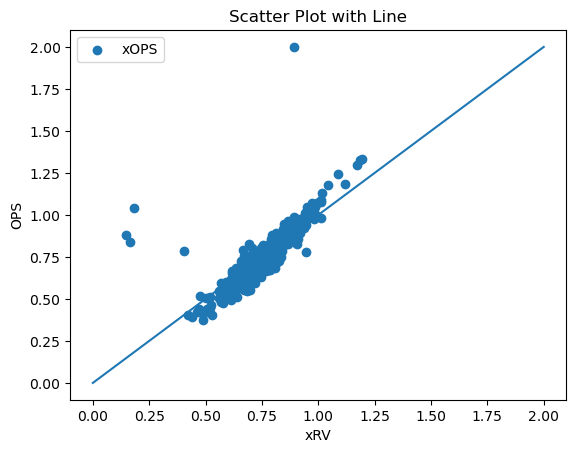

In [42]:
# Plot the scatter plot
#plt.scatter(hitters_mean['xRV'], hitters_mean['OBP'])

# Plot the line
#plt.scatter(hitters_mean['run_value'], hitters_mean['OPS'], label = 'run_value')
#plt.scatter(hitters_mean['xRV'], hitters_mean['OPS'], label = 'xRV')
plt.scatter(hitters_mean['xOPS'], hitters_mean['OPS'], label = 'xOPS')
plt.plot([0,2],[0,2])
# Add labels to the axes and title to the plot
plt.xlabel('xRV')
plt.ylabel('OPS')
plt.title('Scatter Plot with Line')

# Show the plot
plt.legend()
plt.show()


## Stolen Base Break-Even-Rate

In [43]:
b = 1.37
s = 0.97
c = 0.37

ber = round(-(s-b) / ((s-b) - (c-b)),2)
ber

0.67

## Lineup Simulator

In [46]:
def simulate_game(lineup, stats, pxp):
    
    pxp = pxp.reset_index(drop=True)
    
    outs = 0
    runs = 0
    hitter = 0
    inning = 0
    state = '0000'
    
    while inning < 9:
        
        batter_result = get_random_result(stats.loc[lineup[hitter],:])

        new_state = pxp.loc[(pxp['state'] == state) & (pxp['simple_results'] == batter_result)].sample(
        ).iloc[0]
        
        inning_id = new_state['inning_id']
                
        next_row = pxp.iloc[new_state.name+1]
        
        next_inning_id = next_row['inning_id']
        
        if next_inning_id == inning_id:

            state = next_row['state']

            runs += new_state['runs_scored']
            
        else:
            
            inning += 1
            state = '0000'
            
        hitter += 1
        if hitter >= 9:
            hitter = 0        

    return runs

In [47]:
def get_random_result(hitter_stats):
    results = ['1B', '2B', '3B', 'BB', 'FO', 'GO', 'HBP', 'HR', 'K', 'LO']
    weights = [hitter_stats[result] for result in results]
    total_weight = sum(weights)
    weight_probs = [weight / total_weight for weight in weights]
    result = random.choices(results, weights=weight_probs)[0]
    return result

In [48]:
def simulate_n_games(lineup, stats, pxp, n=10):
    
    runs = 0
    
    for game in range(0,n):
    
        runs += simulate_game(lineup, stats, pxp)

    runs_per_game = runs/n
    
    return runs_per_game

In [49]:
import time

def simulate_n_lineups(lineups, stats, pxp, n=1000):
    
    for lineup,stat in zip(lineups, stats):

        then = time.time()

        print(f'{lineup}:')
        
        print(simulate_n_games(lineup, stat, pxp, n))

        now = time.time()

        print(now-then)

In [56]:
lineup_1 = ['Sullivan', 'Sirota', 'Lane', 'Macgregor', 'Crossen', 'Maldonado', 'Musacchia', 'Bozzo', 'Mcgee']
lineup_2 = ['Lane', 'Sirota', 'Sullivan', 'Crossen','Macgregor', 'Maldonado', 'Musacchia', 'Beckstein', 'Bozzo']
lineup_3 = ['Sirota', 'Sullivan', 'Smith', 'Lane','Bosland', 'Crossen', 'Macgregor', 'Maldonado', 'Bozzo']
lineup_4 = ['Sirota', 'Macgregor', 'Lane', 'Lane','Crossen', 'Sullivan', 'Musacchia', 'Bozzo', 'Beckstein']
lineup_5 = ['Lane', 'Sirota', 'Crossen', 'Macgregor','Sullivan', 'Smith', 'Musacchia', 'Bozzo', 'Beckstein']
lineup_6 = ['Sullivan', 'Sirota', 'Musacchia', 'Lane','Crossen', 'Smith', 'Musacchia', 'Bozzo', 'Beckstein']
lineup_7 = ['Sirota', 'Sirota', 'Sirota', 'Sirota','Sirota', 'Sirota', 'Sirota', 'Sirota', 'Sirota']
lineup_8 = ['Costello', 'Diloreto', 'Olson', 'Crossen','Bosland', 'Beckstein', 'Viera', 'Masiuk', 'Smith']
lineup_9 = ['Costello', 'Holzwasser', 'Dupere', 'Viera','Crossen', 'Malgeri', 'Fair', 'Olson', 'Smith']

lineups = [lineup_1, lineup_2, lineup_3, lineup_4, lineup_5, lineup_6]

In [57]:
simulate_n_games(lineup_7, nu_int, pxp, n=40)

13.95